# Modelo de Asignación Generalizada (GAP)

In [9]:
!python -m pip install -i https://pypi.gurobi.com gurobipy
!pip install haversine

Looking in indexes: https://pypi.gurobi.com, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Implementación

In [10]:
import random
from gurobipy import*
from haversine import haversine
import numpy as np
import pandas as pd

# Cargar Datos
coord_df = pd.read_excel('Coordenadas.xlsx', sheet_name = 'Hoja1')
produccion = pd.read_excel('Produccion.xlsx', sheet_name = 'Hoja1')

# Definir los conjuntos
n = 180 # Número de fincas
k = 11 # Número de clusters
F = [i for i in range(n)] # Fincas
K = [j for j in range(k)] # Clusters

ejeX = list(coord_df['Longitud'])
ejeY = list(coord_df['Latitud'])
u = []
for j in range(len(ejeX)):
  u.append((ejeY[j], ejeX[j])) # Ubicación de cada finca
centrosIniciales = [] # Asignar de forma aleatoria los k centroides a fincas existentes
listaRand = random.sample(range(n), k)
for aleAct in listaRand:
  centrosIniciales.append(u[aleAct])

# Definir los parámetros
# Distancia entre cada finca y cada cluster (km)
contFinca = 0
d = {}
for fincaAct in u:
  contCentro = 0
  for centro in centrosIniciales:
    # Vector con las distancias entre la finca actual y todos los centroides actuales
    d[(contFinca, contCentro)] = haversine(fincaAct, centro)
    contCentro += 1
  contFinca += 1

# Producción de cada finca (ton)
p = list(produccion['Producción'])

# Capacidad máxima de producción de cada cluster (ton)
#divi = (np.sum(p)/k)
divi = 6000
c = [divi for i in range(k)]

# Crear el modelo
modeloAsignacion = Model('SudokuMatematico')
modeloAsignacion.setParam('OutputFlag', 0)

# Crear las variables de decisión
x = modeloAsignacion.addVars(F, K, vtype = GRB.BINARY)

# Restricciones del Problema
# La producción de las fincas no puede superar la capacidad de los clusters
for j in K:
  modeloAsignacion.addConstr(quicksum(x[i, j] * p[i] for i in F) <= c[j])
# Cada finca sólo puede ser asignada a una única planta
for i in F:
  modeloAsignacion.addConstr(quicksum(x[i, j] for j in K) == 1)

# Función Objetivo
modeloAsignacion.setObjective(quicksum(x[i, j] * d[i, j] for i in F for j in K), GRB.MINIMIZE)

# Resolver
modeloAsignacion.optimize()

## Resultados

### Gráfica Clusters en el espacio

Función Objetivo: 1412.375304957286


Coords cluster: 6.894, -71.746 ----	 Prod: 50  ----	 NFincas: 10.0
Coords cluster: 6.704, -71.712 ----	 Prod: 195  ----	 NFincas: 34.0
Coords cluster: 6.583, -71.498 ----	 Prod: 106  ----	 NFincas: 19.0
Coords cluster: 7.006, -71.823 ----	 Prod: 240  ----	 NFincas: 40.0
Coords cluster: 6.947, -71.241 ----	 Prod: 110  ----	 NFincas: 22.0
Coords cluster: 6.934, -71.108 ----	 Prod: 27  ----	 NFincas: 4.0
Coords cluster: 6.973, -71.142 ----	 Prod: 61  ----	 NFincas: 12.0
Coords cluster: 6.676, -71.224 ----	 Prod: 39  ----	 NFincas: 7.0
Coords cluster: 6.661, -71.581 ----	 Prod: 149  ----	 NFincas: 26.0
Coords cluster: 6.895, -71.749 ----	 Prod: 8  ----	 NFincas: 2.0
Coords cluster: 6.936, -71.11 ----	 Prod: 28  ----	 NFincas: 4.0




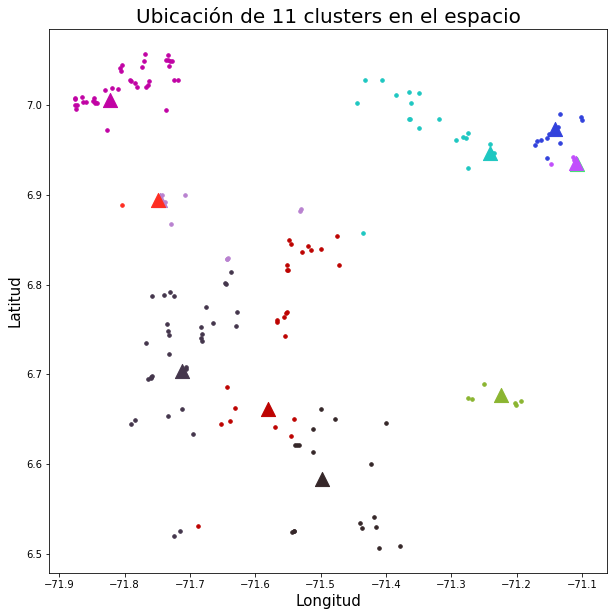

In [11]:
import matplotlib.pyplot as plt

# Imprimir los resultados
print(f'Función Objetivo: {modeloAsignacion.getObjective().getValue()}')
print('\n')
for j in K:
  sumaFincas = 0
  sumaProd = 0
  for i in F:
    if x[i, j].x == 1:
      sumaFincas += x[i, j].x
      sumaProd += p[i]
  print(f'Coords cluster: {round(centrosIniciales[j][0], 3)}, {round(centrosIniciales[j][1], 3)} ----\t Prod: {sumaProd}  ----\t NFincas: {sumaFincas}')

print('\n')
from matplotlib import markers
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

for j in K:
  tuplaColor = (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
  plt.scatter(centrosIniciales[j][1], centrosIniciales[j][0], color = tuplaColor, marker = "^", s = 200)
  for i in F:
    if x[i, j].x == 1:
      plt.scatter(u[i][1], u[i][0], color = tuplaColor, marker = ".", s = 50)

plt.xlabel('Longitud', fontsize = 15)
plt.ylabel('Latitud', fontsize = 15)
plt.title('Ubicación de 11 clusters en el espacio', fontsize = 20)
plt.show()

### Gráfica Suma de Errores [Distancias]

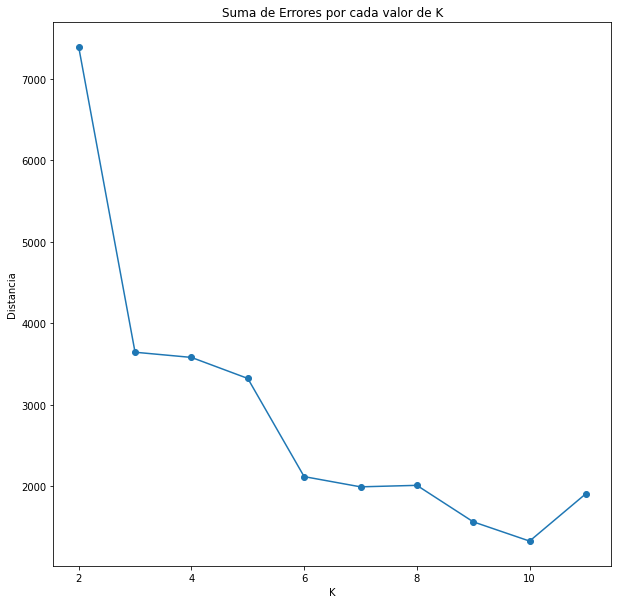

In [12]:
import random
from gurobipy import*
from haversine import haversine
import numpy as np
import pandas as pd
distVector = []
kMax = 12
# Cargar Datos
coord_df = pd.read_excel('Coordenadas.xlsx', sheet_name = 'Hoja1')
produccion = pd.read_excel('Produccion.xlsx', sheet_name = 'Hoja1')
for k in range(2, kMax):
  # Definir los conjuntos
  n = 180 # Número de fincas
  F = [i for i in range(n)] # Fincas
  K = [j for j in range(k)] # Clusters

  u = []
  for j in range(len(ejeX)):
    u.append((ejeY[j], ejeX[j])) # Ubicación de cada finca
  centrosIniciales = [] # Asignar de forma aleatoria los k centroides a fincas existentes
  listaRand = random.sample(range(n), k)
  for aleAct in listaRand:
    centrosIniciales.append(u[aleAct])

  # Definir los parámetros
  # Distancia entre cada finca y cada cluster (km)
  contFinca = 0
  d = {}
  for fincaAct in u:
    contCentro = 0
    for centro in centrosIniciales:
      # Vector con las distancias entre la finca actual y todos los centroides actuales
      d[(contFinca, contCentro)] = haversine(fincaAct, centro)
      contCentro += 1
    contFinca += 1

  # Producción de cada finca (ton)
  p = list(produccion['Producción'])

  # Capacidad máxima de producción de cada cluster (ton)
  #divi = (np.sum(p)/k)
  divi = 100000
  c = [divi for i in range(k)]

  # Crear el modelo
  modeloAsignacion = Model('SudokuMatematico')
  modeloAsignacion.setParam('OutputFlag', 0)

  # Crear las variables de decisión
  x = modeloAsignacion.addVars(F, K, vtype = GRB.BINARY)

  # Restricciones del Problema
  # La producción de las fincas no puede superar la capacidad de los clusters
  for j in K:
    modeloAsignacion.addConstr(quicksum(x[i, j] * p[i] for i in F) <= c[j])
  # Cada finca sólo puede ser asignada a una única planta
  for i in F:
    modeloAsignacion.addConstr(quicksum(x[i, j] for j in K) == 1)

  # Función Objetivo
  modeloAsignacion.setObjective(quicksum(x[i, j] * d[i, j] for i in F for j in K), GRB.MINIMIZE)

  # Resolver
  modeloAsignacion.optimize()

  # Vector de distancias
  distVector.append(modeloAsignacion.getObjective().getValue())

# Graficar
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.scatter([i for i in range(2, kMax)], distVector)
plt.plot([i for i in range(2, kMax)], distVector)
plt.xlabel('K')
plt.ylabel('Distancia')
plt.title('Suma de Errores por cada valor de K')
plt.show()

### Gráfica Coeficientes de Silhouette

Coeficientes de silhouette:
K = 2 -> coeficiente = 0.4657148679655367
K = 3 -> coeficiente = 0.3036577768742392
K = 4 -> coeficiente = 0.2267057925927844
K = 5 -> coeficiente = 0.4425468537649251
K = 6 -> coeficiente = 0.4007100309529969
K = 7 -> coeficiente = 0.16635446405286097
K = 8 -> coeficiente = 0.2999928280508717
K = 9 -> coeficiente = 0.20803766809038507
K = 10 -> coeficiente = 0.3357583238963849
K = 11 -> coeficiente = 0.18992288181087932


Porcentaje de clusters que superan el 5%:  0.0




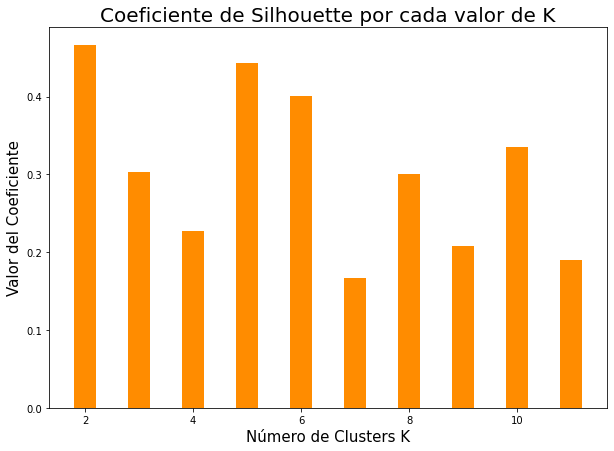

In [13]:
kMax = 11
silhouette = []
for k in range(2, kMax+1):
  # Definir los conjuntos
  n = 180 # Número de fincas
  F = [i for i in range(n)] # Fincas
  K = [j for j in range(k)] # Clusters

  u = []
  for j in range(len(ejeX)):
    u.append((ejeY[j], ejeX[j])) # Ubicación de cada finca
  centrosIniciales = [] # Asignar de forma aleatoria los k centroides a fincas existentes
  listaRand = random.sample(range(n), k)
  for aleAct in listaRand:
    centrosIniciales.append(u[aleAct])

  # Definir los parámetros
  # Distancia entre cada finca y cada cluster (km)
  contFinca = 0
  d = {}
  for fincaAct in u:
    contCentro = 0
    for centro in centrosIniciales:
      # Vector con las distancias entre la finca actual y todos los centroides actuales
      d[(contFinca, contCentro)] = haversine(fincaAct, centro)
      contCentro += 1
    contFinca += 1

  # Producción de cada finca (ton)
  p = list(produccion['Producción'])

  # Capacidad máxima de producción de cada cluster (ton)
  #divi = (np.sum(p)/k)
  divi = 100000
  c = [divi for i in range(k)]

  # Crear el modelo
  modeloAsignacion = Model('SudokuMatematico')
  modeloAsignacion.setParam('OutputFlag', 0)

  # Crear las variables de decisión
  x = modeloAsignacion.addVars(F, K, vtype = GRB.BINARY)

  # Restricciones del Problema
  # La producción de las fincas no puede superar la capacidad de los clusters
  for j in K:
    modeloAsignacion.addConstr(quicksum(x[i, j] * p[i] for i in F) <= c[j])
  # Cada finca sólo puede ser asignada a una única planta
  for i in F:
    modeloAsignacion.addConstr(quicksum(x[i, j] for j in K) == 1)

  # Función Objetivo
  modeloAsignacion.setObjective(quicksum(x[i, j] * d[i, j] for i in F for j in K), GRB.MINIMIZE)

  # Resolver
  modeloAsignacion.optimize()

  # ======================================================= #
  # ================ MÉTRICA DE SILHOUETTE ================ #
  # ======================================================= #

  # Guardar asignaciones actuales en una lista con coordenadas
  dictAsignacion = {}
  for j in K:
    dictAsignacion[j] = []
    for i in F:
      if x[i, j].x == 1:
        dictAsignacion[j].append(i) # Coordenada con (Cluster, Finca)

  vectA = []
  # Cálculo de la cohesión (a(i))
  for j in K:
    listaFincasAct = dictAsignacion[j] # Lista de las fincas asignadas al cluster actual
    nFincas = len(listaFincasAct) - 1 # Cantidad de fincas para promediar la distancia (sin contar la actual)
    if nFincas > 0:
      for fincaAct in listaFincasAct: # Doble recorrido para calcular distancia entre cada finca y el resto en el cluster
        sumaDistancias = 0
        for finca in listaFincasAct:
          sumaDistancias += haversine(u[fincaAct], u[finca])
        promedioDist = sumaDistancias / nFincas # Promediar la distancia de cada finca a las demás 
        vectA.append((fincaAct, promedioDist))

  vectB = []
  # Cálculo de la separación (b(i))
  for j in K:
    listaFincasAct = dictAsignacion[j] # Lista de las fincas asignadas al cluster actual
    for fincaAct in listaFincasAct: # Finca actual evaluada en relación con las demás de los away clusters
      listaPromedios = []
      for p in K: # Recorrer los otros clusters formados
        if p != j:
          sumaDistanciasCluster = 0 
          listaFincasAwayCluster = dictAsignacion[p] # Lista de las fincas asignadas a cada cluster diferente al actual
          nFincas = len(listaFincasAwayCluster) # Cantidad de fincas para promediar la distancia en el away cluster
          for finca in listaFincasAwayCluster:
            sumaDistanciasCluster += haversine(u[fincaAct], u[finca])
          promedioDistCluster = sumaDistanciasCluster / nFincas # Promediar la distancia de cada finca a las demás 
          listaPromedios.append(promedioDistCluster) # Agregar el promedio de distancia de la finca actual a las fincas en el away cluster
      # Se guarda el mínimo de promedios entre la finca actual y los away clusters evaluados
      vectB.append((fincaAct, min(listaPromedios)))

  # Coeficiente de Silhouette por cada finca
  coefSilhouFincas = []
  suma = 0
  for fink in range(len(vectA)):
    a = vectA[fink][1]
    b = vectB[fink][1]
    c_i = (b - a) / max(a, b)
    coefSilhouFincas.append(c_i)

  # Coeficiente de Silhouette de la iteración actual
  silhouette.append((sum(coefSilhouFincas)/len(coefSilhouFincas)))

print('Coeficientes de silhouette:')
p = 0
for k in range(2, kMax+1):
  print(f'K = {k} -> coeficiente = {silhouette[p]}')
  p += 1
print('\n')

je = 0
for a in silhouette:
  if a > 0.5:
    je += 1
print('Porcentaje de clusters que superan el 5%: ', je/len(silhouette))
print('\n')

# Gráfica del Coeficiente para cada K
ks = [k for k in range(2, 12)]
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
plt.bar(ks, silhouette, color ='darkorange', width = 0.4)
plt.xlabel('Número de Clusters K', fontsize = 15)
plt.ylabel('Valor del Coeficiente', fontsize = 15)
plt.title('Coeficiente de Silhouette por cada valor de K', fontsize = 20)
plt.show()